# Graph Analysis Script
This script will contain the following analyses:
* Spectral Graph Partitioning
* Node Degree Centrality Analysis
* Hierarchy Index Calculation
* Rich Club Coefficient Calculation
* Triangulative Potential Analysis

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [1]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Overwriting graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

### Additional Imports:
* To calculate the Rich Club coefficient (particularly the random degree distribution graphs), the package random_graph needs to be imported in the terminal by typing ``` pip install git+https://github.com/jamesross2/random_graph ```


In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import scipy.sparse as sparse
import warnings
import random_graph
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.special import binom as nchoosek
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from skimage.transform.pyramids import pyramid_expand as expand
from skimage.transform.pyramids import pyramid_reduce as reduce
from matplotlib import gridspec
from matplotlib.colors import ListedColormap

import Ressources.TransformHelper as TransformHelper
import pickle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data
    
def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])
    


# Git Paths
OG_DATA_PATH = './'
GIT_DATA_PATH = './Data Exploration/'
GIT_PROCESSED_DATA_PATH = './Results/'
GIT_GRAPH_PATH = './Results/Graphs/'
RESSOURCES_PATH = './Ressources/'
    

# Getting the Folder without hidden files in ascending order 
GIT_PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(GIT_PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_GRAPH_FOLDER = sorted([f for f in os.listdir(GIT_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')
    
    
# External data for mapping 
transform_infos = load_from_disk("./Ressources/map_image_transform_infos.pickle")
transform_matrix = transform_infos["perspective_transform_matrix"]

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")


# Global variables
fontsize = 20
fontweight = 'bold'
labelfontsize = 30
figurelabels = ['A','B','C','D']


green = [0.40,0.80,0.42]
blue = [0.27,0.38,0.99]
yellow = [0.96,0.73,0.23]
darkblue = [0.18, 0.19, 0.69]
lightyellow = [0.9763, 0.9831, 0.0538] 
grey = [0.75,0.75,0.75]
white = [1,1,1]

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)





### Extracting all subject IDs from the data folder

In [255]:
subIDs = []
for sub in GIT_PROCESSED_DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1004 1005 1008 1010 1011 1013 1017 1018 1019 1021 1022 1023 1054 1055
 1056 1057 1058 1068 1069 1072 1073 1074 1075 1077 1079 1080]


In [2]:
# custom subID
subIDs = [1074]


### Loading the edgelists and creating the graphs 
* Also including the analyses

In [58]:
# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
save_bool = False # if you want to save the respective figure
plot_edges_bool = False # if you want to plot the graph's edges
save_centrality = False # if you want to save the centrality dataframe (node degree) as csv 

calculate_Partitioning = False # if you want to calculate the graph partitioning
calculate_Hierarchy = False  # if you want to calculate the hierarchy index 
calculate_RC = False # if you want to calculate the rich club coefficient
calculate_triang = False  # if you want to calculate the triangulation

subcount = 0 # count subjects


            
# use if statements to avoid overwrite
if calculate_Partitioning:
    PartitioningDoc = pd.DataFrame()
if calculate_Hierarchy:
    HierarchyIndexDoc = pd.DataFrame()
if calculate_RC:
    RichClubDoc = pd.DataFrame()
if calculate_triang:
    gazes = pd.DataFrame(columns=['ColliderName', 'Samples', 'timeDiff', 'Index', 'HMD_x', 'HMD_y','HMD_z'])
    noise = pd.DataFrame(columns=['ColliderName', 'Samples', 'timeDiff', 'Index', 'HMD_x', 'HMD_y','HMD_z'])




# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                             if f.startswith(str(subject)+'_edgelist')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
            try:
                edge_list = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " edgelist!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 



    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

    # Remove the NoHit Node
    G.remove_node('NoHouse')
    
    # Remove the NoHit Node
    G.remove_node('NoHit')
    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)
    nodearray = np.array(G.nodes)
    
    
    # coord dict
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')

    # degree dict and list of the graph
    degree_dict = dict(G.degree)
    degree_list = list(degree_dict.values())

    # --------- ANALYSIS ---------

    # --------- PARTITIONING ---------
    if calculate_Partitioning == True: 
        
        # PREPARATION: 
        
        part_G = G
        unconnected_components_amount = 0
        not_connected_amount = 0
        
        # Removing all not connected nodes from the graph
        # The amount needs to be saved in the Partitioning doc
        not_connected_bool = [value == 0 for value in degree_dict.values()]
        not_connected_nodes = nodearray[not_connected_bool]
        not_connected_amount = len(not_connected_nodes)
        
        # remove not connected nodes and components
        for node in not_connected_nodes: part_G.remove_node(node)
            
            
        if len(dict(enumerate(nx.connected_components(part_G))).keys()) == 2:
            # Also removing the unconnected components, i.e. subgraphs and saving their size
            unconnected_components = dict(enumerate(nx.connected_components(part_G)))[1]
            unconnected_components_amount = len(unconnected_components)
            for component in unconnected_components: part_G.remove_node(component)
        elif len(dict(enumerate(nx.connected_components(part_G))).keys()) > 2:
            print('More than two subgraph components, continued!')
            continue
        

        node_array_partitioning = np.array(part_G.nodes)
        
        # START Partitioning algorithm
        # ---- Step 1 ----
        
        # get laplacian matrix and its eigenvalues + eigenvectors
        laplacian_matrix = nx.laplacian_matrix(part_G)
        laplacian_matrix = sparse.csr_matrix.toarray(laplacian_matrix)
        # Eigenvalues and vectors
        Eigenvalue, Eigenvector = np.linalg.eig(laplacian_matrix)
        # sort Eigenvalues in ascending order and use index to sort eigenvectors
        index_array = np.argsort(Eigenvalue)
    
        # check if smallest eigenvalue is 0 (or close to 0)
        if Eigenvalue[index_array][0] < 1e-10:
            #print('smallest Eigenvalue is 0')
            # check if second smallest eigenvalue is larger 0 (this means the graph is fully connected)
            if Eigenvalue[index_array][1] > 1e-10:
                #print('Graph is fully connected')
                
                # create a dataframe and assign both the eigenvector sorted
                house_eig_df = pd.DataFrame()
                house_eig_df['House'] = node_array_partitioning
                house_eig_df['Eigenvector'] = Eigenvector[:,index_array[1]]
                
                sorted_house_arrangement = house_eig_df.sort_values(by='Eigenvector', ascending=True).House.values
                
                
                eig_pos = house_eig_df[house_eig_df.Eigenvector >= 0]
                eig_neg = house_eig_df[house_eig_df.Eigenvector < 0]
                
                
                # make sure to have Cluster continuity with top down though that
                # the clusters are always devided into left and right part of the city 
                # Castle-TaskBuilding_56 is at the left side of the city and used as an anchor here
                # Therefore this condition only holds for this specific data and is for visualization purposes
                if 'Castle-TaskBuilding_56' in eig_pos.House.values:
                    # create the subgraphs
                    posG = part_G.subgraph(eig_pos.House)
                    negG = part_G.subgraph(eig_neg.House)
                else:
                    # create the subgraphs
                    negG = part_G.subgraph(eig_pos.House)
                    posG = part_G.subgraph(eig_neg.House)
                    
                
                # Calculate number of edges and how many were cut
                totalEdges = part_G.number_of_edges()
                    
        
                C1_Edges = posG.number_of_edges() 
                C2_Edges = negG.number_of_edges()
                combinedEdges = C1_Edges + C2_Edges
                Cut_Edges = totalEdges - combinedEdges
                # Calculate number of nodes
                total_nodes = part_G.number_of_nodes()
                C1_nodes = posG.number_of_nodes()
                C2_nodes = negG.number_of_nodes()
                # Calculate the density
                total_density = totalEdges/nchoosek(total_nodes,2)
                C1_density = C1_Edges/nchoosek(C1_nodes,2)
                C2_density = C2_Edges/nchoosek(C2_nodes,2)
                
                
                # Adding the values to the partitioning documentation dataframe
                partitioning_sub_df = pd.DataFrame()
                partitioning_sub_df.loc[0, 'Subject'] = subject
                partitioning_sub_df.loc[0, 'Unconnected Nodes'] = not_connected_amount
                partitioning_sub_df.loc[0, 'Unconnected Component Nodes'] = unconnected_components_amount
                partitioning_sub_df.loc[0, 'Eigenvalue'] = Eigenvalue[index_array][1]
                partitioning_sub_df.loc[0, 'Complete Edges'] = totalEdges
                partitioning_sub_df.loc[0, 'L Edges'] = C1_Edges
                partitioning_sub_df.loc[0, 'R Edges'] = C2_Edges
                partitioning_sub_df.loc[0, 'Cut Edges'] = Cut_Edges
                partitioning_sub_df.loc[0, 'Total Nodes'] = total_nodes
                partitioning_sub_df.loc[0, 'L Nodes'] = C1_nodes
                partitioning_sub_df.loc[0, 'R Nodes'] = C2_nodes
                partitioning_sub_df.loc[0, 'Complete Degree'] = (totalEdges*2)/total_nodes
                partitioning_sub_df.loc[0, 'L Degree'] = C1_Edges/C1_nodes*2
                partitioning_sub_df.loc[0, 'R Degree'] = C2_Edges/C2_nodes*2
                partitioning_sub_df.loc[0, 'Complete Density'] = total_density
                partitioning_sub_df.loc[0, 'L Density'] = C1_density
                partitioning_sub_df.loc[0, 'R Density'] = C2_density               

                
                PartitioningDoc = PartitioningDoc.append(partitioning_sub_df)
                
                
                
                # ------- PLOTTING ---------
                
                if Plotting_bool == True:
                    
                    # ----- Preparation 

                    figgy = plt.figure(figsize=(15,10), constrained_layout=False)

                    cMap = ListedColormap([white, blue, green])

                    # create grid for different subplots                    
                    gs = gridspec.GridSpec(ncols=2, nrows=2, 
                                              width_ratios=[1, 2.5],
                                              height_ratios=[1, 1],
                                              wspace=0.1,
                                              hspace=0.3)


                    # ----- plotting the spy matrix 
                    ax1 = figgy.add_subplot(gs[0])

                    # sort the adjacency matrix according to the eigenvector
                
                    adj = sparse.csr_matrix.toarray(nx.adjacency_matrix(G, nodelist=sorted_house_arrangement))
                                     
                    # assign 2 to all connections of the positive cluster
                    

                    plt.imshow(adj, cmap=cMap)
                    
                    plt.xlim(0, len(G.nodes))
                    plt.ylim(len(G.nodes), 0)


                    # settings
                    plt.xlabel('Matrix Entry', fontsize=fontsize, weight='bold')
                    plt.ylabel('Matrix Entry', fontsize=fontsize, weight='bold')
                    plt.rc('xtick', labelsize=fontsize-5) 
                    plt.rc('ytick', labelsize=fontsize-5)
                    plt.xticks([0,100,200])
                    plt.yticks([0,100,200])



                    # ----- Plotting the graph on the map 
                    ax2 = figgy.add_subplot(gs[0:, -1])
                    ax2.set_adjustable('box', share=False)
                    ax2.set_frame_on(False)

                    # plot the map
                    plt.xlim(0, 4096)
                    plt.ylim(0, 4096)

                    plt.axis('off')
                    plt.imshow(white_bg_img,aspect=ax2.get_aspect(),
                             extent= ax2.get_xlim() + ax2.get_ylim(),
                             zorder=1, alpha=0.8)

                    # Draw the graph 
                    vmin = np.min(degree_list)
                    vmax = np.max(degree_list)

                    # plotting the clusters
                    # positive cluster
                    nx.draw_networkx_nodes(posG, node_color = blue, pos=node_pos, node_size=100)
                    # negative cluster
                    nx.draw_networkx_nodes(negG, node_color = green, pos=node_pos, node_size=100)


                    if plot_edges_bool == True:
                        nx.draw_networkx_edges(G, 
                                               node_pos, 
                                               edge_color='k', 
                                               alpha=0.5, 
                                               width=1,
                                               style='dashed')



                    ax2.set_xlim(0,3800)
                    ax2.set_ylim(300,3700)  


                    # ----- Plotting the eigenvector 
                    ax3 = figgy.add_subplot(gs[2], sharex=ax1)
                    ax3.set_adjustable('box')

                    plot_eig = house_eig_df.sort_values(by='Eigenvector').reset_index()
                    plot_eig_neg = plot_eig.Eigenvector[plot_eig.Eigenvector<0]
                    plot_eig_pos = plot_eig.Eigenvector[plot_eig.Eigenvector>=0]

                    plt.plot(plot_eig_neg, linewidth = 5, color =green)
                    plt.plot(plot_eig_pos, linewidth = 5, color =blue)

                    # settings
                    plt.xlabel('Eigenvector Entry', fontsize=fontsize, weight='bold')
                    plt.ylabel('Eigenvector Value', fontsize=fontsize, weight='bold')
                    plt.yticks([-0.2,-0.1,0,0.1,0.2])
                    
                    plt.setp(ax1.get_xticklabels(), Fontsize=fontsize+5)
                    plt.setp(ax1.get_yticklabels(), Fontsize=fontsize+5)

                    plt.setp(ax3.get_xticklabels(), Fontsize=fontsize+5)
                    plt.setp(ax3.get_yticklabels(), Fontsize=fontsize+5)

                    # figure labels
                    ax1.text(-44,-15,figurelabels[0],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
                    ax2.text(-220,3760,figurelabels[1],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
                    ax3.text(-44,0.235,figurelabels[2],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
                        
                    
                    # save the graph as png 
                    if save_bool == True:
                        # saving the subject info dataframe
                        try:
                            plt.savefig(GIT_GRAPH_PATH + str(subject) + "_Cluster_Figure.png",
                                        dpi=100,
                                        format="PNG",
                                        facecolor='white',
                                        transparent=False, 
                                        bbox_inches = "tight")

                            print("\tCluster Figure PNG saved")
                        except:
                            print("\tCould not save subject " + str(subject) + " Cluster Figure as PNG!")


                    #plt.close()
          
            else:
                print('Graph is not fully connected')

                
                
    # --------- HIERARCHY INDEX ---------
    if calculate_Hierarchy == True: 
        # get the median degree as a reference
        median_degree = np.median(degree_list)

        # get a list of unique degree values
        UniqueDegree = np.unique(degree_list)
        UniqueDegreeMed = UniqueDegree[UniqueDegree >= median_degree]

        # get the frequency of each degree value
        DegreeFrequency = dict()

        for degree in UniqueDegree:
            DegreeFrequency[degree] = np.sum(degree_list==degree)

        DegreeFrequencyMed = np.array(list(DegreeFrequency.values()))[UniqueDegree >= median_degree]

        # do a linear fit of the log data of Unique Degree over Frequency
        linear_model=np.polyfit(np.log(UniqueDegreeMed),np.log(DegreeFrequencyMed),1)
        linear_model_fn=np.poly1d(linear_model)

        # save the hierarchy index (the slope of the fit)
        hierarchy_sub_df = pd.DataFrame()
        hierarchy_sub_df.loc[0, 'Subject'] = subject
        hierarchy_sub_df.loc[0, 'HierarchyIndex'] = -linear_model[0]

        HierarchyIndexDoc = HierarchyIndexDoc.append(hierarchy_sub_df)

        
        # ------- PLOTTING ---------
                
        if Plotting_bool == True:

            plt.figure(figsize=(15,10))
            plt.scatter(np.log(UniqueDegree),np.log(list(DegreeFrequency.values())), )

            x_s=np.arange(np.log(median_degree) ,max(np.log(UniqueDegree)+0.5))
            plt.plot(x_s, linear_model_fn(x_s),color=green, linewidth=4)

            # settings
            plt.title('Hierarchy Index - Subject ' + str(subject), fontsize=fontsize)
            plt.xlabel('Degree', fontsize=fontsize)
            plt.ylabel('Frequency', fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.yticks(fontsize=fontsize)

            if save_bool == True:
                    # saving the figure
                    try:
                        plt.savefig(GIT_GRAPH_PATH + str(subject) + "_HierarchyIndex.png",
                                    dpi=200,
                                    format="PNG",
                                    facecolor='white',
                                    transparent=False, 
                                    bbox_inches = "tight")
                    except:
                        print("\tCould not save subject " + str(subject) + " HierarchyIndex as PNG!")


    
    # --------- RICH CLUB COEFFICIENT ---------
    if calculate_RC == True:
        
        RichClub_sub = pd.DataFrame()    
            
        # calculate the rich club for the subject graph
        RC = nx.rich_club_coefficient(G, normalized=False, seed=1)

        # create a random graph for the rich club weighting with the same degree distribution
        edges = random_graph.sample_simple_graph(degree_list)
        randomG = nx.Graph()
        randomG = nx.from_edgelist(edges)

        # calculate the ric club for the random graph
        RC_random = nx.rich_club_coefficient(randomG, normalized=False, seed=2)
        
        RichClub_sub[str(subject)] = np.array(list(RC.values()))/np.array(list(RC_random.values()))
        #RichClub_sub = [i / j for i, j in zip(list(RC.values()), list(RC_random.values()))]
        RichClub_sub.reset_index(drop=True,inplace=True)
        #RichClubDoc = RichClubDoc.append(RichClub_sub)
        
        
        if len(RichClubDoc) != 0 and (len(RichClubDoc) < len(RichClub_sub)):
            RichClubDoc = RichClubDoc.reindex(range(max(len(RichClubDoc), len(RichClub_sub))))
               
        RichClubDoc[str(subject)] = RichClub_sub[str(subject)]
        
        
        # -------- PLOTTING ---------
        if Plotting_bool == True:
            plt.figure(figsize=(10,7))
            plt.plot(RichClub_sub[str(subject)],
                     linewidth=3,
                     color=green)

            # settings
            plt.title('Rich Club - Subject ' + str(subject), fontsize=fontsize)
            plt.xlabel('Degree', fontsize=fontsize)
            plt.ylabel('Rich Club (Real/Random)', fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            plt.ylim(0.8,2)
    

            # --------- SAVING ---------
            if save_bool == True:
                # saving the figure
                try:
                    plt.savefig(GIT_GRAPH_PATH + str(subject) + "_RichClub.png",
                                format="PNG",
                                facecolor='white',
                                transparent=False, 
                                bbox_inches = "tight")
                except:
                    print("\tCould not save subject " + str(subject) + " RichCLub as PNG!")
    

    # --------- TRIANGULATION ---------
    if calculate_triang == True: 
        
        # get the interpolation files according to the subject
        interpolation_folder = sorted([f for f in GIT_PROCESSED_DATA_FOLDER 
                                 if f.startswith(str(subject)+'_interpolation')], key=str.lower)

        if len(interpolation_folder) != 0:        
            # open the JSON file as dictionary
            with open(GIT_PROCESSED_DATA_PATH + interpolation_folder[0]) as f:
                try:
                    interpolation_data = pd.read_csv(f)
                except:
                    print("\tCould not load subject " + str(subject) + " edgelist!")

        else:
            print('Subject ' + str(subject) + ' has no interpolation file!')
            continue 

        sub_gazes = pd.DataFrame(columns=gazes.columns)
        sub_noise = pd.DataFrame(columns=gazes.columns)

        sub_gazes = sub_gazes.append(interpolation_data[interpolation_data.timeDiff>0.2333])
        
        sub_noise = sub_noise.append(interpolation_data[interpolation_data.timeDiff<=0.2333])        



        gazes = gazes.append(sub_gazes)
        gazes.reset_index(drop=True, inplace=True)
        
        noise = noise.append(sub_noise)        
        noise.reset_index(drop=True, inplace=True)


    

if save_bool == True: 
    # saving the subject info dataframe
    try:
        PartitioningDoc.to_csv(GIT_GRAPH_PATH
                        + "PartitioningDoc.csv", 
                        index=False)
        
        print("Partitioning Dataframe saved")
        
    except:
        pass     
    
    try:

        HierarchyIndexDoc.to_csv(GIT_GRAPH_PATH
                        + "HierarchyTable.csv", 
                        index=False)
        print("Hierarchy Dataframe saved")
    except:
        pass   
    
    try:
        RichClubDoc.to_csv(GIT_GRAPH_PATH
                + "RichClubDoc.csv", 
                index=False)
        print("Rich Club Dataframe saved")
    except:
        pass
        
    try:   
        gazes.to_csv(GIT_GRAPH_PATH
                                + "all_gazes.csv", 
                                index=False)

        print("All gazes Dataframe saved")
        
    except:
        pass
            
    try:   
        noise.to_csv(GIT_GRAPH_PATH
                                + "all_noise.csv", 
                                index=False)

        print("All noise Dataframe saved")
        
    except:
        pass





    
print('Done')
   

Subject 1074 started - 1/1
Done


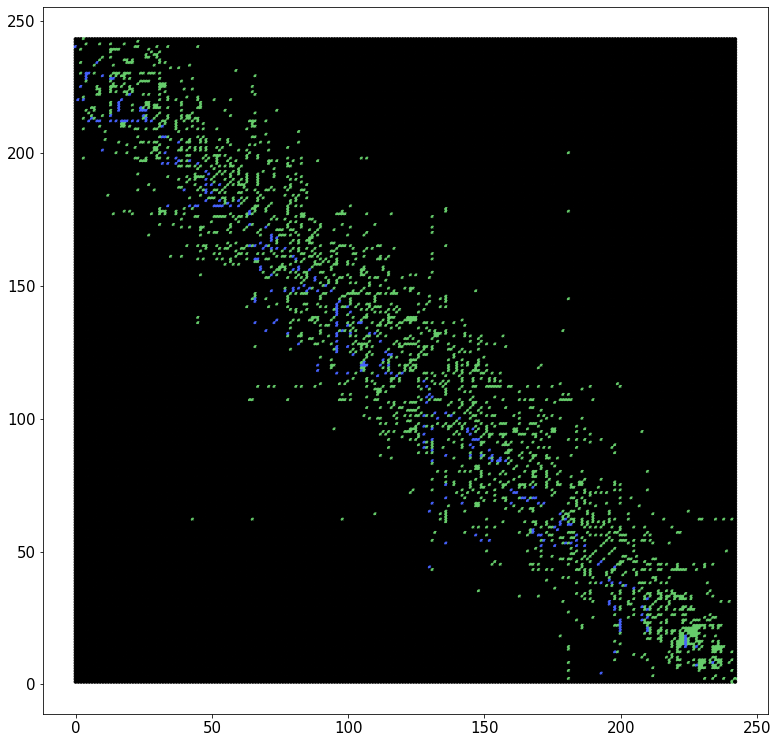

In [229]:
adj_test = adj.copy()
for i in range(np.shape(adj)[0]):
    for j in range(np.shape(adj)[1]):
        if (adj_test[i,j] == 1) & (i in np.array(eig_pos.index) | j in np.array(eig_pos.index)):
            adj_test[i,j] = 2

im = np.zeros([np.shape(adj)[0],np.shape(adj)[1],3])
im[adj_test==0] = np.nan
im[adj_test==1] = green
im[adj_test==2] = blue


# add color dimension
#im = im[..., np.newaxis]


# generate coordinates for the image. Note that the image is "top down", so the y coordinate goes from high to low.
ys, xs = np.mgrid[im.shape[0]:0:-1, 0:im.shape[1]]

plt.figure(figsize=(13,13))
# Scatter plots take 1d arrays of xs and ys, and the colour takes a 2d array,
# with the second dimension being RGB
plt.scatter(xs.flatten(), ys.flatten(), s=10,
            c=im.flatten().reshape(-1, 3), edgecolor='face')
plt.show()

## Subject Overviews


### General Viewing Stats
* requires to run triangulation from previous cell

In [217]:
# open the JSON file as dictionary
with open(GIT_PROCESSED_DATA_PATH + 'Subject_Data.csv') as f:
    try:
        subject_info = pd.read_csv(f)
    except:
            print("\tCould not load subject info")
            
subject_info['DataLoss BitMask'] = subject_info['DataLoss BitMask']*100
subject_info['DataLoss NoHits'] = subject_info['DataLoss NoHits']*100
subject_info['DataLoss Combined'] = subject_info['DataLoss Combined']*100
subject_info['Removed rows (%)'] = subject_info['Removed rows (%)']*100
            
mean_stats = pd.DataFrame(columns=subject_info.columns)

mean_stats.loc[0] = subject_info.mean().round(2)



mean_stats.to_csv(GIT_GRAPH_PATH
                + "AverageSubViewingDoc.csv", 
                index=False)

print("AverageSubViewingDoc Dataframe saved")


AverageSubViewingDoc Dataframe saved


/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


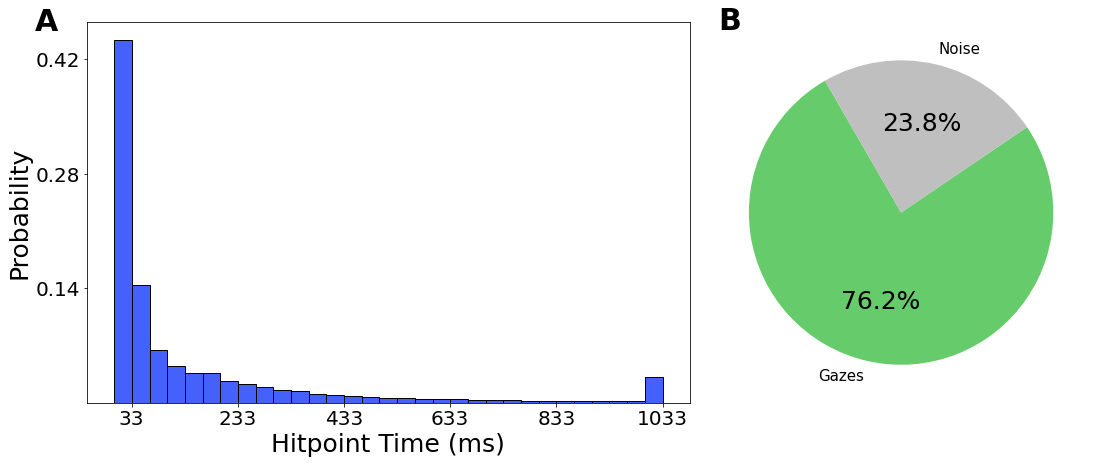

In [212]:
save_bool = True # True if you want to save the figure

# load gazes and noise file
gazes = pd.read_csv(GIT_GRAPH_PATH+ "all_gazes.csv")
noise = pd.read_csv(GIT_GRAPH_PATH+ "all_noise.csv")


all_views = np.concatenate((gazes.timeDiff.values, noise.timeDiff.values), axis=0)

all_views[all_views>1.033] = 1.033

all_views = all_views*1000

# Data to plot
labels = 'Gazes', 'Noise'
sizes = [np.sum(gazes.timeDiff), np.sum(noise.timeDiff)]
colors = [green, grey]
explode = (0, 0, 0, 0)  # explode 1st slice



figgy = plt.figure(figsize=(20,7))

gs = gridspec.GridSpec(ncols=2, nrows=1, 
                       width_ratios=[1, 1],
                       wspace=-0.15)

ax1 = figgy.add_subplot(gs[0])
plt.hist(all_views, 31, ec='k', color=blue)
ax1.set_xlabel('Hitpoint Time (ms)', fontsize=fontsize+10)
ax1.set_ylabel('Probability', fontsize=fontsize+10)
ax1.set_xticks([33, 233, 433, 633, 833, 1033])
ax1.set_yticks([180000, 360000, 540000])
prob_ticks = [round(180000/len(all_views),2), round(360000/len(all_views),2), round(540000/len(all_views),2)]
ax1.set_yticklabels(prob_ticks)

plt.setp(ax1.get_xticklabels(), Fontsize=fontsize+5)
plt.setp(ax1.get_yticklabels(), Fontsize=fontsize+5)

plt.text(-150,585000,figurelabels[0],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})



ax2 = figgy.add_subplot(gs[1])
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=120)
plt.rcParams['font.size'] = labelfontsize-5


ax2.text(-1.2,1.2,figurelabels[1],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})

# ---------- SAVING ---------

if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "Gaze_Stat_Figure.png",
                    dpi=200,
                    format="PNG",
                    facecolor='white',
                    transparent=False, 
                    bbox_inches = "tight")
    except:
        print("\tCould not save Gaze Stat Figure as PNG!")

### Partitioning 

In [219]:
PartitioningDoc

,Subject,Unconnected Nodes,Unconnected Component Nodes,Eigenvalue,Complete Edges,L Edges,R Edges,Cut Edges,Total Nodes,L Nodes,R Nodes,Complete Degree,L Degree,R Degree,Complete Density,L Density,R Density
0,1004.0,4.0,0.0,0.171716,901.0,599.0,245.0,57.0,238.0,157.0,81.0,7.571429,7.630573,6.049383,0.031947,0.048914,0.075617
0,1005.0,2.0,0.0,0.160241,695.0,428.0,226.0,41.0,235.0,139.0,96.0,5.914894,6.158273,4.708333,0.025277,0.044625,0.049561
0,1008.0,0.0,0.0,0.205503,1091.0,769.0,262.0,60.0,241.0,161.0,80.0,9.053942,9.552795,6.550000,0.037725,0.059705,0.082911
0,1010.0,0.0,0.0,0.208254,1043.0,663.0,319.0,61.0,240.0,141.0,99.0,8.691667,9.404255,6.444444,0.036367,0.067173,0.065760
0,1011.0,0.0,0.0,0.195463,1002.0,725.0,229.0,48.0,242.0,161.0,81.0,8.280992,9.006211,5.654321,0.034361,0.056289,0.070679
0,1013.0,0.0,0.0,0.147601,1003.0,731.0,233.0,39.0,239.0,163.0,76.0,8.393305,8.969325,6.131579,0.035266,0.055366,0.081754
0,1017.0,0.0,0.0,0.300397,1151.0,596.0,455.0,100.0,242.0,132.0,110.0,9.512397,9.030303,8.272727,0.039471,0.068934,0.075897
0,1018.0,3.0,0.0,0.089601,758.0,568.0,148.0,42.0,236.0,174.0,62.0,6.423729,6.528736,4.774194,0.027335,0.037738,0.078265
0,1019.0,3.0,2.0,0.181875,884.0,656.0,188.0,40.0,233.0,159.0,74.0,7.587983,8.251572,5.081081,0.032707,0.052225,0.069604
0,1021.0,2.0,0.0,0.174986,821.0,541.0,240.0,40.0,234.0,141.0,93.0,7.017094,7.673759,5.161290,0.030116,0.054813,0.056101


In [2]:
# open the JSON file as dictionary
with open(GIT_GRAPH_PATH + 'PartitioningDoc.csv') as f:
    try:
        PartitioningDoc = pd.read_csv(f)
    except:
            print("\tCould not load PartitioningDoc")
            
mean_part = pd.DataFrame(columns=PartitioningDoc.columns)

mean_part.loc[0] = PartitioningDoc.mean().round(2)



mean_part.to_csv(GIT_GRAPH_PATH
                + "AveragePartitioningDoc.csv", 
                index=False)

print("AveragePartitioningDoc Dataframe saved")

AveragePartitioningDoc Dataframe saved


### Node Degree
* Calculate the following figures:
     1. Errorbar plot of all subjects
     2. Imagescale plot of all subjects over houses with ascendingly ordered degree
     3. Correlation of inter subject degree distributions 
     4. Errorbar plot of all houses

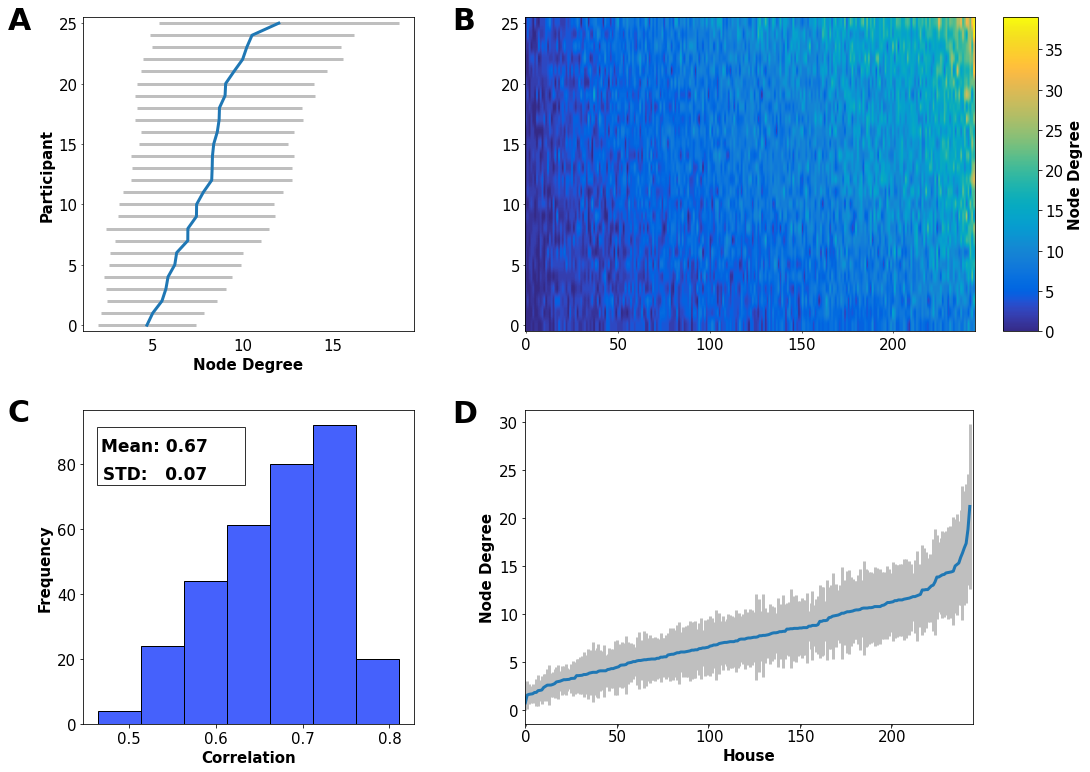

In [114]:
save_bool = True # True if you want to save the figure

# open the Node degree csv file as dictionary
with open(GIT_GRAPH_PATH + 'centrality_df.csv') as f:
    try:
        centrality_df = pd.read_csv(f)
    except:
            print("\tCould not load centrality_df!")
            
            
            

# create a pure degree dataframe by removing mean and std values 
pure_degree = centrality_df.drop(['Mean', 'STD'], axis=1)
pure_degree = pure_degree.drop(pure_degree[(pure_degree.Subject == 'Mean') | (pure_degree.Subject == 'STD')].index)

# create lists for mean/std degree over subjects and houses 
mean_degree_subs = pure_degree.iloc[:, 1:].mean(axis=1).copy()
std_degree_subs = pure_degree.iloc[:, 1:].std(axis=1).copy()
mean_degree_houses = pure_degree.iloc[:, 1:].mean(axis=0).copy()
std_degree_houses = pure_degree.iloc[:, 1:].std(axis=0).copy()

# sort index 
sub_sort_index = np.argsort(mean_degree_subs)
house_sort_index = np.argsort(mean_degree_houses)

sorted_cent = pure_degree.iloc[:, 1:].copy()
sorted_cent = sorted_cent.reindex(sorted_cent.mean(axis=1).sort_values(ascending=False).index,
                                  axis=0)
sorted_cent.reset_index(drop=True,inplace=True)
sorted_cent = sorted_cent[pure_degree.columns[1:][house_sort_index]]
sorted_cent.fillna(0, inplace=True)


# calculating the correlation coefficients
correlation_matrix = pure_degree.iloc[:, 1:].T.corr().copy()
# creating a mask to get the lower diagonal of the matrix
correlation_matrix = correlation_matrix.mask(np.triu(np.ones(correlation_matrix.shape, dtype=np.bool_)))
# squeeze non nans to list 
correlation_list = np.asarray(correlation_matrix).reshape(-1)
correlation_list = correlation_list[~np.isnan(correlation_list)]




# ---------- PLOTTING ------------
        


# -------- NODE DEGREE INFO PLOT -----------



# preparation

subticks = list(np.array(range(0,26,5)) + 0.5)
subticklabel = np.array(range(0,26,5))
subticklabel = ["%.d" % x for x in subticklabel]

houseticks = list(np.array(range(0,244,50)) + 0.5)
houseticklabel = np.array(range(0,244,50))
houseticklabel = ["%.d" % x for x in houseticklabel]


figgy = plt.figure(figsize=(18,13))
# create grid for different subplots
gs = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[1, 1.7], wspace=0.25,
                         hspace=0.25, height_ratios=[1, 1])

# errorbar plot 
ax1 = figgy.add_subplot(gs[0])
ax1.set_adjustable('box', share=True)
# Customize minor tick labels
ax1.set_yticklabels('')
ax1.set_yticks(subticks,      minor=True)
ax1.set_yticklabels(subticklabel, minor=True)

plt.errorbar(mean_degree_subs[sub_sort_index],
             np.arange(0.5, len(mean_degree_subs)+0.5),
             xerr=std_degree_subs[sub_sort_index],
             ecolor=grey,
             mfc=blue,
             linewidth = 3)

plt.xlabel('Node Degree', fontsize=fontsize, weight=fontweight)
plt.ylabel('Participant', fontsize=fontsize, weight=fontweight)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)
plt.tick_params(top=False, bottom=False, left=False, right=False)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)



# image scale plot
ax2 = figgy.add_subplot(gs[1], sharey = ax1)

plt.imshow(sorted_cent,
           extent=[0, np.shape(pure_degree)[1], 0, np.shape(pure_degree)[0]],
           cmap=parula_map)


cbar = plt.colorbar(shrink=1, aspect=9)
cbar.set_label('Node Degree', fontsize=fontsize, weight=fontweight)
ax2.set_aspect('auto')
ax2.set_adjustable('box', share=True)
# Customize minor tick labels
ax2.set_xticklabels('')
ax2.set_xticks(houseticks,      minor=True)
ax2.set_xticklabels(houseticklabel, minor=True)
plt.tick_params(top=False, bottom=False, left=False, right=False)




# correlation histogram
ax3 = figgy.add_subplot(gs[2])
ax3.set_adjustable('box', share=True)

plt.hist(correlation_list, ec='k', bins=7, color=blue)

plt.xlabel('Correlation', fontsize=fontsize, weight=fontweight)
plt.ylabel('Frequency', fontsize=fontsize, weight=fontweight)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)



# -------------- Rectangle START --------------------

# Mean and STD rectangle
rect_loc = (plt.xlim()[0] + 0.02*plt.xlim()[1], plt.ylim()[1] - 0.24*plt.ylim()[1])
mean_loc = (plt.xlim()[0] + 0.025*plt.xlim()[1], plt.ylim()[1] - 0.13*plt.ylim()[1])
std_loc = (plt.xlim()[0] + 0.02*plt.xlim()[1], plt.ylim()[1] - 0.22*plt.ylim()[1])

rect1 = plt.Rectangle(rect_loc,(0.17),(18), facecolor=white,edgecolor="black",alpha=0.8)
plt.gca().add_patch(rect1)

mean_corr = round(np.mean(correlation_list),2)
std_corr = round(np.std(correlation_list),2)
# Mean Info
plt.text(mean_loc[0]
         ,mean_loc[1]
         , "Mean: " + str(mean_corr)
         ,fontsize = fontsize+2
         ,zorder = 5
         ,color = 'k'
         ,fontweight = fontweight)
# STD Info
plt.text(std_loc[0]
         ,std_loc[1]
         , " STD:   " + str(std_corr)
         ,fontsize = fontsize+2
         ,zorder = 5
         ,color = 'k'
         ,fontweight = fontweight)



# -------------- Rectangle END --------------------


# errorbar plot for houses 
ax4 = figgy.add_subplot(gs[3], sharex = ax2)
ax4.set_adjustable('box', share=True)
ax4.set_aspect(5.25, anchor='SW')

plt.errorbar(np.arange(0, len(mean_degree_houses)),
             mean_degree_houses[house_sort_index],
             yerr=std_degree_houses[house_sort_index],
             ecolor=grey,
             mfc=blue,
             linewidth = 3)



plt.xlabel('House', fontsize=fontsize, weight=fontweight)
plt.ylabel('Node Degree', fontsize=fontsize, weight=fontweight)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)


# Figure Labels
ax1.text(-3,25,figurelabels[0],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax2.text(-40,25,figurelabels[1],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax3.text(0.36,93,figurelabels[2],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax4.text(-40,30,figurelabels[3],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})


# ---------- SAVING ---------

if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "NodeDegree_all.png",
                    dpi=200,
                    format="PNG",
                    facecolor='white',
                    transparent=False, 
                    bbox_inches = "tight")
    except:
        print("\tCould not save NodeDegree Figure as PNG!")



# Landmark Figure

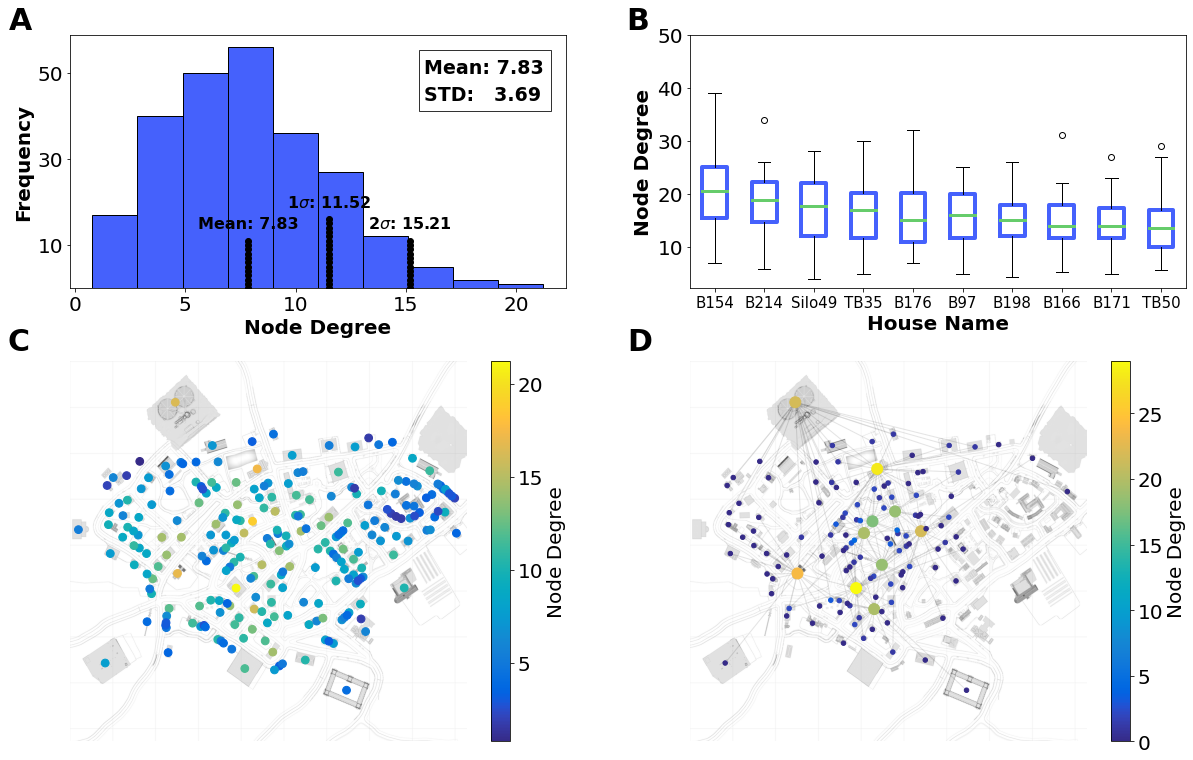

In [108]:
plot_edges_bool = False
save_bool = True


# PREPARATION 
subIDs = [1074]

# open the JSON file as dictionary
with open(GIT_GRAPH_PATH + '1074_edgelist.csv') as f:
    try:
        edge_list = pd.read_csv(f)
    except:
            print("\tCould not load subject " + str(subject) + " edgelist!")


# create graph from edgelist
G = nx.Graph()
G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

# Remove the NoHouse Node
G.remove_node('NoHouse')
# Remove the NoHit Node
G.remove_node('NoHit')
# Setting the node coordinates of each node of the graph


# node list
nodelist = list(G.nodes)
nodearray = np.array(G.nodes)


# coord dict
node_pos = {}

for node in nodelist:
    # assign node coordinates
    x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
    y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
    node_pos[node] = (x,y) 

# set the graph's node coordinates attribute
nx.set_node_attributes(G, node_pos, 'coord')

# degree list of the graph
degree_list = list(dict(G.degree).values())
    
    

fontsize = 15

mean_degrees = centrality_df[centrality_df.Subject == 'Mean']
mean_degrees = mean_degrees.drop(['Subject','Mean', 'STD'], axis=1)
top10_houses = mean_degrees.sort_values(by=26, ascending=False, axis=1).columns[:10]



top10_edgelist = edge_list.copy()
top10_edgelist = \
    top10_edgelist[top10_edgelist['Edge1'].isin(top10_houses) | top10_edgelist['Edge2'].isin(top10_houses)]


# create graph from edgelist
top10_graph = nx.Graph()
top10_graph = nx.from_pandas_edgelist(top10_edgelist, 'Edge1', 'Edge2')

top10_graph.remove_node('NoHouse')
top10_graph.remove_node('NoHit')

top10_degree_list = list(dict(top10_graph.degree).values())

# get the average degree over subjects and sort them according to the node order of the donor subject
mean_dict = centrality_df[centrality_df['Subject'] == 'Mean'].to_dict('records')[0]
mean_dict.pop('Mean')
mean_dict.pop('STD')
mean_dict.pop('Subject')

sorted_mean_degrees_dict = dict()
for node in nodelist:
    sorted_mean_degrees_dict[node] = mean_dict[node]
    
sorted_mean_degrees = list(sorted_mean_degrees_dict.values())




# mean node degree distribution at first
# mean node degree distribution at first
mean_degree = round(centrality_df[centrality_df.Subject == 'Mean'].Mean.values[0], 2) 
std_degree =  round(centrality_df[centrality_df.Subject == 'Mean'].STD.values[0], 2)

zero_sigma = centrality_df[centrality_df.Subject == 'Mean'].Mean.values[0]

one_sigma = centrality_df[centrality_df.Subject == 'Mean'].Mean.values[0] \
                + centrality_df[centrality_df.Subject == 'Mean'].STD.values[0]

two_sigma = centrality_df[centrality_df.Subject == 'Mean'].Mean.values[0] \
                + 2*centrality_df[centrality_df.Subject == 'Mean'].STD.values[0]


top10_short = ['B154', 'B214', 'Silo49', 'TB35', 'B176', 'B97', 'B198', 'B166', 'B171', 'TB50']

# -------- PLOTTING --------


# -------- MEAN NODE DEGREE HISTOGRAM -----------



figgy = plt.figure(figsize=(20,13))
# create grid for different subplots
gs = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[1, 1], wspace=0.25,
                         hspace=0.23, height_ratios=[1, 1.5])




ax1 = figgy.add_subplot(gs[0])

#plot
hist_plotty = plt.hist(centrality_df.loc[len(centrality_df)-2][1:], ec='k', color=blue)


# lines for sigma distance
# 0 sigma
plt.plot(np.ones(12)*zero_sigma,np.arange(0,12,1),linestyle='--', marker='o', color='k')
zero_loc = (zero_sigma, 15)

plt.text(zero_loc[0]
         ,zero_loc[1]
         , "Mean: " + str(round(zero_sigma, 2))
         , ha="center"
         , va="center"
         ,fontsize = fontsize+1
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')

# 1 sigma
plt.plot(np.ones(17)*one_sigma,np.arange(0,17,1),linestyle='--', marker='o', color='k')
one_loc = (one_sigma, 20)

plt.text(one_loc[0]
         ,one_loc[1]
         , "1$\sigma$: " + str(round(one_sigma, 2))
         , ha="center"
         , va="center"
         ,fontsize = fontsize+1
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')
# 2 sigma
plt.plot(np.ones(12)*two_sigma,np.arange(0,12,1),linestyle='--', marker='o', color='k')
two_loc = (two_sigma, 15)

plt.text(two_loc[0]
         ,two_loc[1]
         , "2$\sigma$: " + str(round(two_sigma, 2))
         , ha="center"
         , va="center"
         ,fontsize = fontsize+1
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')


# Mean and STD rectangle
rect_loc = (plt.xlim()[1] - 0.3*plt.xlim()[1], plt.ylim()[1] - 0.3*plt.ylim()[1])
mean_loc = (plt.xlim()[1] - 0.29*plt.xlim()[1], plt.ylim()[1] - 0.15*plt.ylim()[1])
std_loc = (plt.xlim()[1] - 0.29*plt.xlim()[1], plt.ylim()[1] - 0.26*plt.ylim()[1])

rect1 = plt.Rectangle(rect_loc,(6),(14), facecolor=white,edgecolor="black",alpha=0.8)
plt.gca().add_patch(rect1)
# Mean Info
plt.text(mean_loc[0]
         ,mean_loc[1]
         , "Mean: " + str(mean_degree)
         ,fontsize = fontsize+4
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')
# STD Info
plt.text(std_loc[0]
         ,std_loc[1]
         , "STD:   " + str(std_degree)
         ,fontsize = fontsize+4
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')


# further settings
plt.xticks([0,5,10,15,20], fontsize=fontsize+5)
plt.yticks([10,30,50], fontsize=fontsize+5)
plt.xlabel('Node Degree', fontsize=fontsize+5, weight='bold')
plt.ylabel('Frequency', fontsize=fontsize+5, weight='bold')
plt.rc('xtick', labelsize=fontsize+5) 
plt.rc('ytick', labelsize=fontsize+5)


# Box Plot
ax2 = figgy.add_subplot(gs[1])
bp = plt.boxplot(centrality_df[top10_houses])

for box in bp['boxes']:
    box.set(linewidth=4, color=blue)

for medians in bp['medians']:
    medians.set(linewidth=3, color=green)
    
plt.xlabel('House Name', fontsize=fontsize+5, weight='bold')
plt.ylabel('Node Degree', fontsize=fontsize+5, weight='bold')

ax2.set_xticklabels(top10_short, fontsize=fontsize)

plt.yticks([10,20,30,40,50], fontsize=fontsize+5)



# Average Graph

ax3 = figgy.add_subplot(gs[2])

# plot the map
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax3.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax3.get_aspect(),
         extent= ax3.get_xlim() + ax3.get_ylim(),
         zorder=1, alpha=0.8)

# Draw the graph 
vmin = np.min(sorted_mean_degrees)
vmax = np.max(sorted_mean_degrees)

nx.draw_networkx_nodes(G,
                       node_pos, 
                       alpha = 1, 
                       node_size = 60, 
                       node_color=sorted_mean_degrees, 
                       cmap=parula_map)

if plot_edges_bool == True:
    nx.draw_networkx_edges(G, 
                           node_pos, 
                           edge_color='k', 
                           alpha=0.5, 
                           width=1,
                           style='dashed')
    

ax3.set_xlim(0,3800)
ax3.set_ylim(300,3700) 
            
            
sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=[0,5,10,15,20])
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Node Degree', size=20)






# Top 10 Houses Graph Plot

ax4 = figgy.add_subplot(gs[3])

# plot the map
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax4.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax4.get_aspect(),
         extent= ax4.get_xlim() + ax4.get_ylim(),
         zorder=1, alpha=0.8)

# Draw the graph 
vmin = np.min(degree_list)
vmax = np.max(degree_list)

node_sizes = np.ones(len(top10_degree_list))*20 # standard node size

node_df = pd.DataFrame(top10_graph.nodes)

node_sizes[node_df.isin(top10_houses).T.values[0]] = 120


nx.draw_networkx_nodes(top10_graph,
                       node_pos, 
                       alpha = 1, 
                       node_size = node_sizes, 
                       node_color=top10_degree_list, 
                       cmap=parula_map)


nx.draw_networkx_edges(top10_graph, 
                       node_pos, 
                       edge_color='k', 
                       alpha=0.5, 
                       width=1,
                       style='solid')



ax4.set_xlim(0,3800)
ax4.set_ylim(300,3700) 



sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Node Degree', size=20)

# Figure Labels
ax1.text(-3,60,figurelabels[0],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax2.text(-0.79,51,figurelabels[1],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax3.text(-600,3800,figurelabels[2],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax4.text(-600,3800,figurelabels[3],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})


# ---------- SAVING ---------

if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "Landmark_Plot.png",
                    dpi=200,
                    format="PNG",
                    facecolor='white',
                    transparent=False, 
                    bbox_inches = "tight")
    except:
        print("\tCould not save Landmark Plot as PNG!")



In [228]:
centrality_df

,Subject,Building_100,Building_101,Building_102,Building_103,Building_104,Building_105,Building_106,Building_107,Building_108,...,TaskBuilding_55,TaskBuilding_6,TaskBuilding_7,TaskBuilding_8,TaskBuilding_9,Windmill-TaskBuilding_10_1,crane_1,crane_2,Mean,STD
0,1004,9.000000,15.000000,8.000000,5.000000,7.000000,2.000000,4.000000,11.000000,10.000000,...,11.000000,12.000000,6.000000,4.000000,7.000000,8.000000,3.000000,3.000000,7.446281,4.269841
1,1005,10.000000,10.000000,6.000000,4.000000,9.000000,3.000000,1.000000,5.000000,8.000000,...,9.000000,8.000000,1.000000,5.000000,8.000000,6.000000,4.000000,3.000000,5.864979,3.518522
2,1008,10.000000,16.000000,13.000000,8.000000,18.000000,9.000000,8.000000,11.000000,8.000000,...,8.000000,11.000000,6.000000,6.000000,5.000000,6.000000,12.000000,5.000000,9.053942,4.894001
3,1010,10.000000,13.000000,8.000000,7.000000,10.000000,7.000000,5.000000,6.000000,16.000000,...,9.000000,14.000000,7.000000,8.000000,8.000000,10.000000,11.000000,6.000000,8.691667,4.638020
4,1011,10.000000,10.000000,5.000000,7.000000,9.000000,3.000000,8.000000,5.000000,12.000000,...,5.000000,12.000000,5.000000,6.000000,8.000000,7.000000,13.000000,2.000000,8.280992,4.469766
5,1013,11.000000,12.000000,10.000000,7.000000,15.000000,2.000000,5.000000,8.000000,8.000000,...,9.000000,17.000000,8.000000,6.000000,7.000000,6.000000,13.000000,5.000000,8.393305,4.125667
6,1017,12.000000,12.000000,7.000000,8.000000,16.000000,7.000000,8.000000,10.000000,13.000000,...,12.000000,15.000000,9.000000,5.000000,10.000000,11.000000,12.000000,3.000000,9.512397,5.128418
7,1018,8.000000,8.000000,6.000000,3.000000,10.000000,2.000000,3.000000,3.000000,11.000000,...,8.000000,5.000000,9.000000,4.000000,4.000000,2.000000,5.000000,1.000000,6.343096,3.681584
8,1019,5.000000,12.000000,6.000000,6.000000,10.000000,3.000000,5.000000,10.000000,7.000000,...,10.000000,8.000000,7.000000,4.000000,7.000000,6.000000,11.000000,4.000000,7.436975,4.337334
9,1021,10.000000,10.000000,8.000000,3.000000,10.000000,5.000000,NaN,4.000000,3.000000,...,10.000000,12.000000,1.000000,3.000000,6.000000,9.000000,10.000000,5.000000,6.957627,4.046315


### Hierarchy Index

/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
/Applications/anaconda3/envs/graphs/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


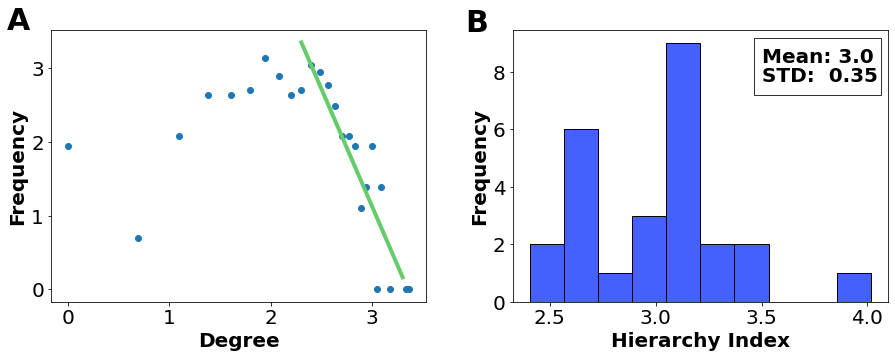

In [54]:
save_bool = True

# open the Node degree csv file as dictionary
with open(GIT_GRAPH_PATH + 'centrality_df.csv') as f:
    try:
        centrality_df = pd.read_csv(f)
    except:
            print("\tCould not load centrality_df!")
            
HierarchyIndexDoc = pd.read_csv('/Users/lessmann/Documents/Uni/GitHub/GTA_ET/Results/Graphs/HierarchyTable.csv')



# PREPARATION

subject_degreelist = centrality_df[centrality_df.Subject == str(subIDs[0])].copy()
subject_degreelist = np.array(subject_degreelist.drop(['Subject', 'Mean', 'STD'], axis=1).values[0])
subject_degreelist = subject_degreelist[~np.isnan(subject_degreelist)]

mean_hier = round(np.mean(HierarchyIndexDoc.HierarchyIndex), 2)
std_hier = round(np.std(HierarchyIndexDoc.HierarchyIndex), 2)

median_degree = np.median(subject_degreelist)

# get a list of unique degree values
UniqueDegree = np.unique(subject_degreelist)
UniqueDegreeMed = UniqueDegree[UniqueDegree >= median_degree]

# get the frequency of each degree value
DegreeFrequency = dict()

for degree in UniqueDegree:
    DegreeFrequency[degree] = np.sum(subject_degreelist==degree)

DegreeFrequencyMed = np.array(list(DegreeFrequency.values()))[UniqueDegree >= median_degree]

# do a linear fit of the log data of Unique Degree over Frequency
linear_model=np.polyfit(np.log(UniqueDegreeMed),np.log(DegreeFrequencyMed),1)
linear_model_fn=np.poly1d(linear_model)

        
    
    
# ---- PLOTTING -----  
            

figgy = plt.figure(figsize=(15,5), constrained_layout=False)

# create grid for different subplots                    
gs = gridspec.GridSpec(ncols=2, nrows=1, 
                          wspace=0.23)

ax1 = figgy.add_subplot(gs[0])

plt.scatter(np.log(UniqueDegree),np.log(list(DegreeFrequency.values())), )

x_s=np.arange(np.log(median_degree) ,max(np.log(UniqueDegree)+0.5))
plt.plot(x_s, linear_model_fn(x_s),color=green, linewidth=4)

# settings
plt.xlabel('Degree', fontsize=fontsize, weight='bold')
plt.ylabel('Frequency', fontsize=fontsize, weight='bold')
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)



ax2 = figgy.add_subplot(gs[1])

plt.hist(HierarchyIndexDoc.HierarchyIndex, ec='k', bins=10, color=blue, align="mid")

# Mean and STD rectangle
rect_loc = (plt.xlim()[1] - 0.155*plt.xlim()[1], plt.ylim()[1] - 0.24*plt.ylim()[1])
mean_loc = (plt.xlim()[1] - 0.145*plt.xlim()[1], plt.ylim()[1] - 0.12*plt.ylim()[1])
std_loc = (plt.xlim()[1] - 0.145*plt.xlim()[1], plt.ylim()[1] - 0.19*plt.ylim()[1])

rect1 = plt.Rectangle(rect_loc,(0.6),(2), facecolor=white,edgecolor="black",alpha=0.8)
plt.gca().add_patch(rect1)
# Mean Info
plt.text(mean_loc[0]
         ,mean_loc[1]
         , "Mean: " + str(mean_hier)
         ,fontsize = fontsize
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')
# STD Info
plt.text(std_loc[0]
         ,std_loc[1]
         , "STD:  " + str(std_hier)
         ,fontsize = fontsize
         ,zorder = 5
         ,color = 'k'
         ,fontweight = 'bold')



plt.xlabel('Hierarchy Index', fontsize=fontsize, weight='bold')
plt.ylabel('Frequency', fontsize=fontsize, weight='bold')
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)


# Figure Labels
ax1.text(-0.6,3.52,figurelabels[0],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax2.text(2.1,9.4,figurelabels[1],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})

# ---------- SAVING ---------

if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "Hierarchy_Figure.png",
                    dpi=200,
                    format="PNG",
                    facecolor='white',
                    transparent=False, 
                    bbox_inches = "tight")
    except:
        print("\tCould not save Hierarchy Figure as PNG!")




### Rich Club Coefficient
* Requires running the Node Degree Cell

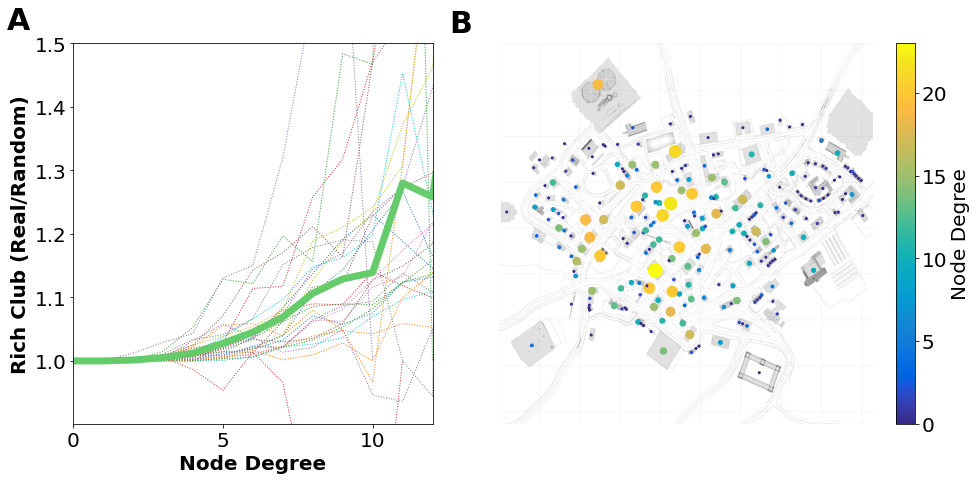

In [81]:
save_bool = True # if you want to save and overwrite 

# load the RC documentation
with open(GIT_GRAPH_PATH + 'RichClubDoc.csv') as f:
    try:
        RichClubDoc = pd.read_csv(f)
    except:
            print("\tCould not load RichClubDoc!")
            
            
RichClubHouses_df = pd.DataFrame(columns=['House', 'Frequency'])
RichClubHouses_df.House = pure_degree.columns[1:]

one_sigma = centrality_df[centrality_df.Subject == 'Mean'].Mean.values[0] \
                + centrality_df[centrality_df.Subject == 'Mean'].STD.values[0]

two_sigma = centrality_df[centrality_df.Subject == 'Mean'].Mean.values[0] \
                + 2*centrality_df[centrality_df.Subject == 'Mean'].STD.values[0]


temp_degree = pure_degree.iloc[:,1:] > one_sigma
RichClubHouses_df.Frequency = temp_degree.sum().values

sorted_rich_dict = dict()
for node in nodelist:
    sorted_rich_dict[node] = RichClubHouses_df.Frequency[RichClubHouses_df.House == node].values[0]
    
sorted_rich = list(sorted_rich_dict.values())



            

figgy = plt.figure(figsize=(16,7), constrained_layout=False)

# create grid for different subplots                    
gs = gridspec.GridSpec(ncols=2, nrows=1, 
                          wspace=0.16,
                          width_ratios=[1, 1.3])

ax1 = figgy.add_subplot(gs[0])


for sub in RichClubDoc.columns:
    plt.plot(RichClubDoc[sub][0:20], linestyle=':', linewidth=1)

meanRC = RichClubDoc.mean(axis=1)   
plt.plot(meanRC[:20], linewidth=7, color=green)    

#plt.title('Rich Club - All', fontsize=fontsize, weight='bold')
plt.xlabel('Node Degree', fontsize=fontsize, weight='bold')
plt.ylabel('Rich Club (Real/Random)', fontsize=fontsize, weight='bold')
plt.xticks([0,5,10,15], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0.901,1.5)
plt.xlim(0,round(one_sigma))


ax2 = figgy.add_subplot(gs[1])

# plot the map
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax2.set_frame_on(False)
plt.axis('off')
plt.imshow(white_bg_img,aspect=ax3.get_aspect(),
         extent= ax2.get_xlim() + ax2.get_ylim(),
         zorder=1, alpha=0.8)

# Draw the graph 
vmin = RichClubHouses_df.Frequency.min()
vmax = RichClubHouses_df.Frequency.max()

size = [np.exp(i/6)*4 for i in sorted_rich]

nx.draw_networkx_nodes(G,
                       node_pos, 
                       alpha = 1, 
                       node_size = size, 
                       node_color=sorted_rich, 
                       cmap=parula_map)

    
ax2.set_xlim(0,3800)
ax2.set_ylim(300,3700) 
    
sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Node Degree', size=20)

# Figure Labels
ax1.text(-2.2,1.522,figurelabels[0],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})
ax2.text(-500,3800,figurelabels[1],fontdict={'fontweight':fontweight,'fontsize':labelfontsize})


# ---------- SAVING ---------

if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "RichClub_All.png",
                    dpi=200,
                    format="PNG",
                    facecolor='white',
                    transparent=False,
                    bbox_inches = "tight")
    except:
        print("\tCould not save RichCLub_All as PNG!")



         

### Triangulation

Transform gaze locations

In [115]:
# load gazes file
gazes = pd.read_csv(GIT_GRAPH_PATH+ "all_gazes.csv")


# transform coordinates
gazes = TransformHelper.apply_perspective_transform_matrix(transform_matrix,
                                                                img_size=(4096,4096),
                                                                dataframe=gazes,
                                                                df_x_name="HMD_x",
                                                                df_y_name="HMD_z",
                                                                transform_x_name="transformed_HMD_x",
                                                                transform_y_name="transformed_HMD_y")

Calculating Perspective Transform for DataFrame...


100%|██████████| 247153/247153 [00:26<00:00, 9309.07it/s] 


In [116]:
# --------- Preparation ---------

# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")


#RichClubHouses = RichClubHouses_df.sort_values(by='Frequency', ascending=False)[:10].House.values
sigma2 = RichClubHouses_df.Frequency.mean()+2*RichClubHouses_df.Frequency.std()
RichClubHouses = RichClubHouses_df[RichClubHouses_df.Frequency>sigma2].sort_values(by='Frequency', ascending=False).House.values


Rich_gazes = gazes[gazes['ColliderName'].isin(RichClubHouses)]
Rich_gazes = Rich_gazes.reset_index(drop=True)

    
rows, cols, colorchannels = np.shape(white_bg_img)

EdgesRows = list(range(0, rows, 16))
EdgesCols = list(range(0, cols, 16))


In [117]:
Locations = np.zeros((int(rows/16),int(cols/16)))


# loop to check which location has been visited
for gaze_idx in range(len(gazes)-1):
    
    x = round(gazes.transformed_HMD_x[gaze_idx]/16)
    y = round(gazes.transformed_HMD_y[gaze_idx]/16)
    
    if Locations[y,x] == 0:
        Locations[y,x] = 1
        Locations[y,x] = int(Locations[y,x])
        
    


# loop to check where Rich Club Houses where visible
for Rich_idx in range(len(Rich_gazes)-1):
    

    x = round(Rich_gazes.transformed_HMD_x[Rich_idx]/16)
    y = round(Rich_gazes.transformed_HMD_y[Rich_idx]/16)
    
    if Locations[y,x] == 0:
        Locations[y,x] = 1
        Locations[y,x] = int(Locations[y,x])
    else:
        Locations[y,x] += 1
        Locations[y,x] = int(Locations[y,x])
    

Locations[Locations>=3] = 3

Locations = expand(Locations, upscale=16)

Locations[Locations == 0] = np.nan   
        
    
print('Done')

Done


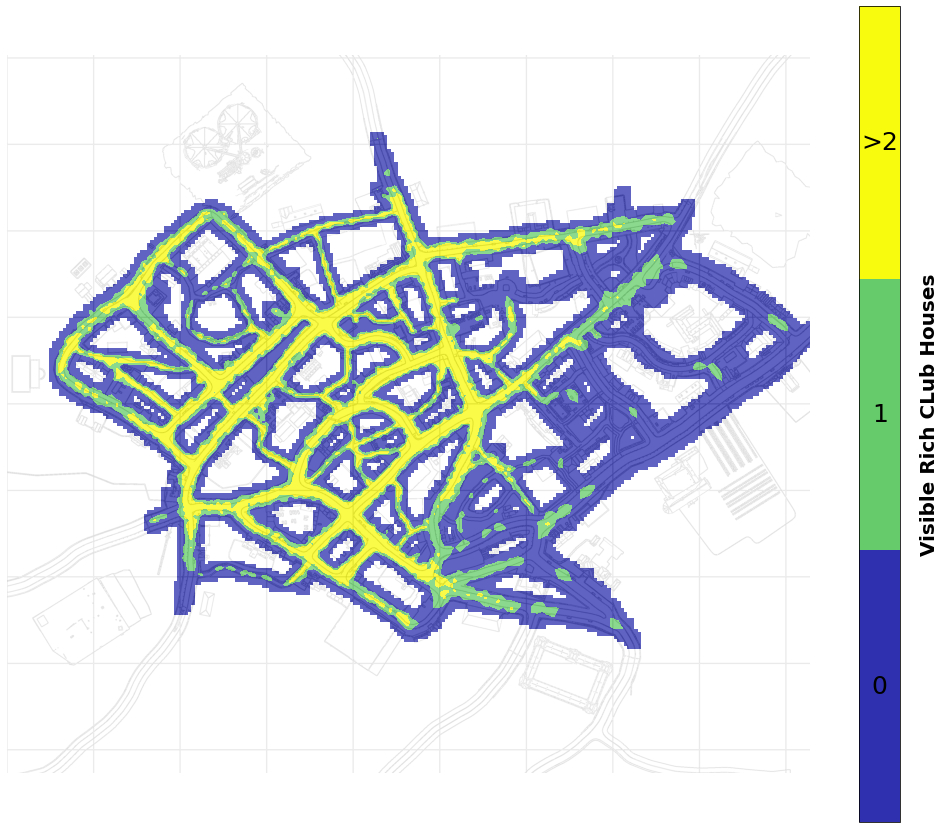

In [128]:
# ---------- PLOTTING ---------   
save_bool = False

#discrete color scheme
cMap = ListedColormap([darkblue, green, lightyellow])


fig = plt.figure(figsize=(20,15))
    
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
plt.axis('off')


# Here, for plot visibility, I am doing a inverse Canny Edge Detection 
# to only plot the binary edge image of the map
plt.imshow(cv2.bitwise_not(cv2.Canny(white_bg_img, threshold1=30, threshold2=100)),
         aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1, alpha=0.25)

plt.gray()



triang = plt.imshow(Locations,
           alpha = 1,
           cmap=cMap)

cbar = plt.colorbar(triang)
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(['0','1','>2']):
    cbar.ax.text(1.5,
                 (2 * j + 1)/2 ,
                 lab,
                 ha='center',
                 va='center',
                 fontsize=fontsize+10)
    
cbar.set_label('Visible Rich CLub Houses', size=fontsize+5, labelpad=20, weight='bold')
    

ax.set_xlim(0,3800)
ax.set_ylim(300,3700) 

    
# ---------- SAVING ---------    

if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "Triangulation_All.png",
                    dpi=200,
                    format="PNG",
                    transparent=False,
                    facecolor='white',
                    bbox_inches = "tight")
    except:
        print("\tCould not save Triangulation_All as PNG!")


